In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
import tarfile
import re
import io
import os

import numpy
import pandas
import matplotlib.pyplot as plt
import dask.array
import IPython.display

import sklearn
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn import metrics
import librosa
import librosa.display
import skimage.io

# Custom modules
import dcase2018bad
import features

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dataset = dcase2018bad.load_dataset()
print(dataset.shape)
dataset.head(3)

(48310, 4)


,itemid,datasetid,hasbird,folder
0,BUK4_20161103_204504_125,PolandNFC,NaN,polandnfc
1,BUK4_20161016_012704_132,PolandNFC,NaN,polandnfc
2,6wichura_deszcz_BUK4_20161005_022304_129,PolandNFC,NaN,polandnfc


In [3]:
trainset = dataset[dataset.hasbird.notna()].copy()
print(trainset.shape)
trainset['hasbird'] = trainset.hasbird.astype(bool)

(35690, 4)


In [4]:
# Reduce dataset to make exploration quicker
trainset = trainset.sample(n=100, random_state=1)
trainset.shape

(100, 4)

In [21]:
withbirds = list(dcase2018bad.wav_urls(trainset[trainset.hasbird == True]))

In [24]:
IPython.display.Audio(withbirds[1])

In [29]:
def extract_melspec(path):
    sr, data = features.read_audio(path)
    data = data.astype(float)
    params = dict(n_mels=64, fmin=500, n_fft=2048, fmax=15000, htk=True)
    mel = librosa.feature.melspectrogram(y=data, sr=sr, **params)
    #mel = mel[:, :800] #cutoff any extra
    #mel = mel.reshape(-1)
    return mel

m = extract_melspec('https://storage.googleapis.com/dcase2018-bad/birdvox/wav/0055615b-c316-43d7-a789-a0f6c2983081.wav')
m.shape

(64, 862)

In [52]:
melspecs = features.extract(dcase2018bad.wav_urls(trainset),
                            feature_extractor=extract_melspec,
                            feature_length=51200, 
                            chunk_size=10)
melspecs

dask.array<concatenate, shape=(100, 51200), dtype=float64, chunksize=(10, 51200)>

In [53]:
melspec_data = melspecs.compute()

In [58]:
melspecs.to_hdf5('melspecs.100.hdf5', '/x')

In [60]:
melspec_float = melspec_data.reshape(100, 64, -1)
# jpeg qualiy 1-100
melspec_float.shape

(100, 64, 800)

In [37]:
IPython.display.Audio(withbirds[1])

scale [18.1458072  19.82520008 22.10639063 22.55456746 22.29882691 21.91700358
 22.07451377 22.10561366 22.21804469 22.24170719]
scalei [18.1458072  19.82520008 22.10639063 22.55456746 22.29882691 21.91700358
 22.07451377 22.10561366 22.21804469 22.24170719]


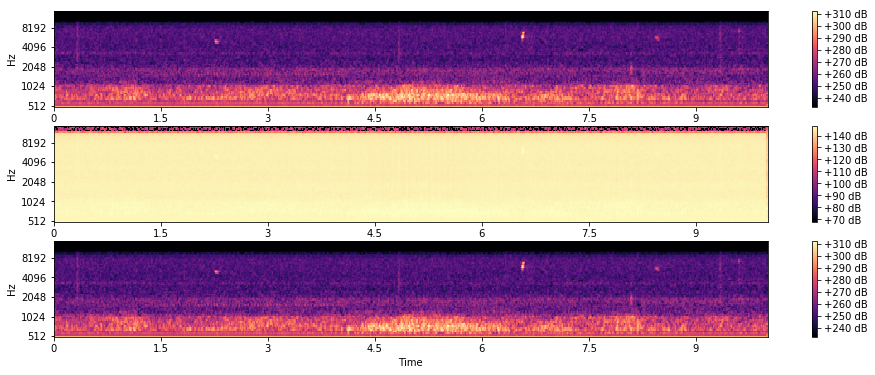

In [131]:
# TODO: use robust scaling instead + clamping
def compress(spec):
    #return numpy.log(spec)

    spec = numpy.log(spec)
    Smin = spec.min(axis=0)
    Smax = spec.max(axis=0)
    spec = (spec - Smin) / (Smax - Smin)
    spec = (spec * (255 - 0) + 0).astype(numpy.uint8)
    assert(numpy.max(spec) <= 255)
    assert(numpy.min(spec) >= 0)

    print('scale', (Smax-Smin)[:10])
    
    return spec, Smin, Smax
    
def decompress(comp, Smin, Smax):
    #return numpy.exp(comp)

    comp = comp.astype(float) / 255.0
    assert(numpy.max(comp) <= 1.0)
    assert(numpy.min(comp) >= 0.0)
    #comp = numpy.exp(comp)
    
    print('scalei', (Smax-Smin)[:10])
    spec = comp
    spec = (spec * ( Smax - Smin )) + Smin
    
    spec = numpy.exp(spec)
    return spec

def display(s):
    #s = numpy.log(s)
    s = s.astype(float)
    #s -= numpy.median(s, axis=0)
    D = librosa.amplitude_to_db(s, ref=0.0)
    librosa.display.specshow(D, fmin=500, fmax=15000, sr=44100, y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    
original = extract_melspec(withbirds[1])
c, smin, smax = compress(original)
d = decompress(c, smin, smax)
plt.figure(figsize=(16,6))
plt.subplot(3, 1, 1)
display(original)
plt.subplot(3, 1, 2)
display(c)
plt.subplot(3, 1, 3)
display(d)

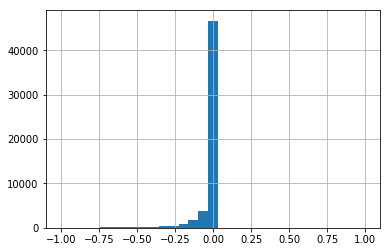

In [169]:
def plot_diff(a, b):
    diff = (a.ravel() - b.ravel())/numpy.max(b.ravel())*100
    pandas.Series(diff).hist(bins=31, range=(-1, 1))
    numpy.min(diff), numpy.max(diff)
    
plot_diff(d, original)

In [135]:
skimage.io.imsave('spec.png', c)
skimage.io.imsave('spec.jpg', c)

scalei [18.1458072  19.82520008 22.10639063 22.55456746 22.29882691 21.91700358
 22.07451377 22.10561366 22.21804469 22.24170719]


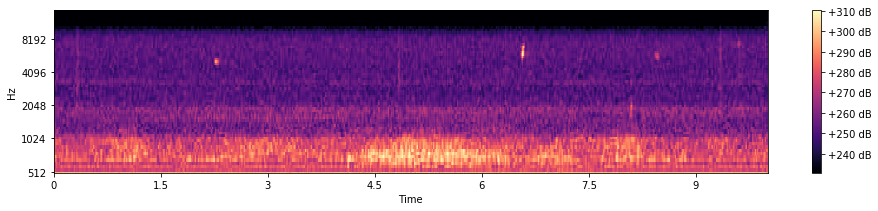

In [184]:
cjpg = decompress(skimage.io.imread('spec.jpg'), smin, smax)
plt.figure(figsize=(16,3))
display(cjpg)

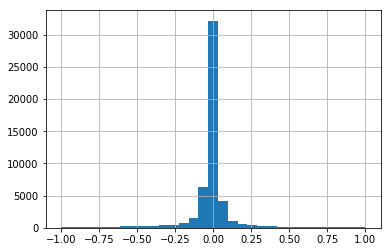

In [171]:
plot_diff(cjpg, original)

scalei [18.1458072  19.82520008 22.10639063 22.55456746 22.29882691 21.91700358
 22.07451377 22.10561366 22.21804469 22.24170719]


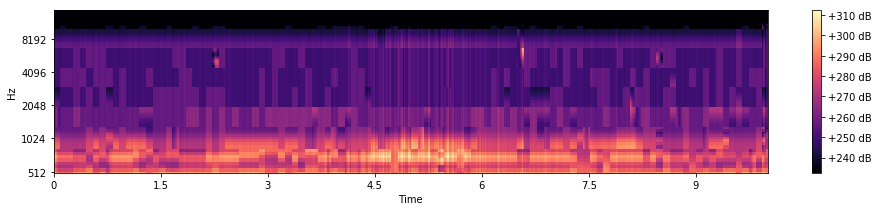

In [183]:
skimage.io.imsave('spec.low.jpg', c, quality=10)
cjpglow = decompress(skimage.io.imread('spec.low.jpg'), smin, smax)
plt.figure(figsize=(16,3))
display(cjpglow)

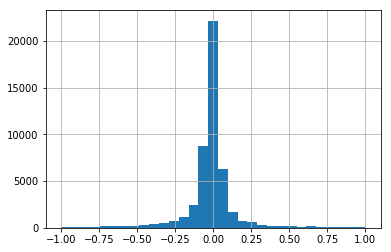

In [175]:
plot_diff(cjpglow, original)

In [180]:
os.stat('spec.low.jpg').st_size

1747

In [181]:
os.stat('spec.jpg').st_size

7867

In [182]:
os.stat('spec.png').st_size

30154

In [6]:
# TODO: test classifiers on compressed spectograms

rf = make_pipeline(
    RandomForestClassifier(n_estimators=100, min_samples_leaf=2, random_state=1),
)

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(train_X, train_Y, test_size=0.3)

start = time.time()
print('Starting train', X_train.shape, numpy.mean(Y_train))
rf.fit(X_train, Y_train)
end = time.time()
print('Train time', end-start)

print('train', model_selection.cross_val_score(rf, X_train, Y_train, scoring='roc_auc', cv=3))
print('test', model_selection.cross_val_score(rf, X_test, Y_test, scoring='roc_auc', cv=3))

NameError: name 'train_X' is not defined